Importing file and checking Distribution

In [1]:
import os
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import librosa
import numpy as np
import matplotlib.pyplot as plt

Prefer not to say records removed


Hispanic or Latino marked as not white records

C:\Users\shrra\AppData\Local\Temp\ipykernel_27980\1924320391.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')


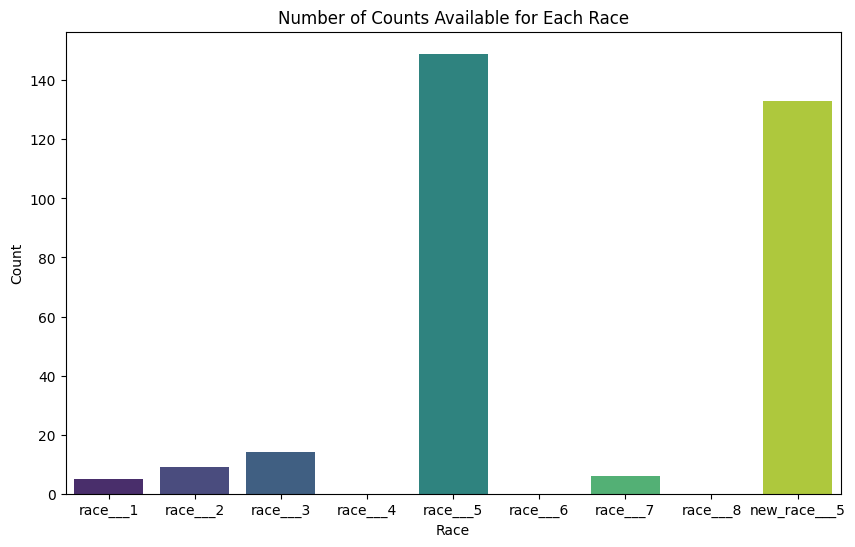

In [2]:


path = "C:/Users/shrra/Downloads/2024-06-25T13-17_export.csv"
datafram =pd.read_csv(path)



def determine_new_race_5(row):
    if row['race___5'] and row['ethnicity'] == "Hispanic or Latino":
        return False
    else:
        return row['race___5']

# Apply the function to create the new column
datafram['new_race___5'] = datafram.apply(determine_new_race_5, axis=1)

# Remove rows where race___5 is false and race___8 is true
datafram = datafram[~((datafram['race___5'] == False) & (datafram['race___8'] == True))]

race_columns = ['race___1', 'race___2', 'race___3', 'race___4', 'race___5','race___6', 'race___7','race___8','new_race___5']  
race_counts = datafram[race_columns].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Number of Counts Available for Each Race')
plt.show()


# income_counts = datafram['household_income_usa'].value_counts()

# # Plotting the counts
# plt.figure(figsize=(10, 6))
# sns.barplot(x=income_counts.index, y=income_counts.values, palette='viridis')
# plt.xlabel('Household Income')
# plt.ylabel('Count')
# plt.title('Number of Counts Available for Each Household Income Bracket')
# plt.show()


Filtering Dataset with rainbow passage file

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import wave

# Assuming `df` is your dataframe
# Replace `datafram` with the actual dataframe name if different
df = datafram
selected_columns = ['record_id', 'demographics_session_id', 'new_race___5']
df = df[selected_columns]

# Add 'subject_id' column
df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']

# Function to check file existence and calculate lengths
def get_valid_subject_ids_and_lengths(df, base_dir='C:/Users/shrra/Downloads/Bridge2AI/bridge2ai-voice-corpus-2-including-sensitive-recordings1/bids_with_sensitive_recordings/'):
    valid_ids = []
    all_lengths = []
    for subject_id in df['subject_id']:
        session_dir = os.path.join(base_dir, subject_id, 'audio')
        if os.path.exists(session_dir):
            for file_name in os.listdir(session_dir):
                if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):  # Check for .wav files
                    file_path = os.path.join(session_dir, file_name)
                    with wave.open(file_path, 'r') as wav_file:
                        frames = wav_file.getnframes()
                        rate = wav_file.getframerate()
                        duration = frames / float(rate)
                    valid_ids.append(subject_id)
                    all_lengths.append(duration)
                    break
    return valid_ids, all_lengths

# Get valid subject IDs and lengths
valid_subject_ids, all_lengths = get_valid_subject_ids_and_lengths(df)

# Filter the dataframe to include only records with valid subject IDs
df = df[df['subject_id'].isin(valid_subject_ids)]

# Split the data into train+val and test sets (80% train+val, 20% test)
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['new_race___5'], random_state=42)

# Split the train+val set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['new_race___5'], random_state=42)  # 0.25 * 0.8 = 0.2

# Display the number of records in each distribution
def display_distribution(df, name):
    print(f"Distribution in {name}:")
    print(df['new_race___5'].value_counts())
    print()

display_distribution(df, 'Filtered Set')
display_distribution(train_df, 'Train Set')
display_distribution(val_df, 'Validation Set')
display_distribution(test_df, 'Test Set')

# Calculate the overall minimum and maximum lengths
overall_min_length = min(all_lengths)
overall_max_length = max(all_lengths)

# Display the overall min and max lengths
print(f"Overall Minimum Length of .wav files: {overall_min_length:.2f} seconds")
print(f"Overall Maximum Length of .wav files: {overall_max_length:.2f} seconds")


Distribution in Filtered Set:
new_race___5
True     128
False     39
Name: count, dtype: int64

Distribution in Train Set:
new_race___5
True     76
False    23
Name: count, dtype: int64

Distribution in Validation Set:
new_race___5
True     26
False     8
Name: count, dtype: int64

Distribution in Test Set:
new_race___5
True     26
False     8
Name: count, dtype: int64

Overall Minimum Length of .wav files: 17.68 seconds
Overall Maximum Length of .wav files: 142.41 seconds


C:\Users\shrra\AppData\Local\Temp\ipykernel_27980\3314202843.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']


Epoch 1/20


c:\Users\shrra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.5148 - loss: 1177.3450 - val_accuracy: 0.7647 - val_loss: 293.2449
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.7852 - loss: 189.6622 - val_accuracy: 0.7647 - val_loss: 27.9833
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.4116 - loss: 49.9926 - val_accuracy: 0.7647 - val_loss: 13.3104
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.7373 - loss: 14.8267 - val_accuracy: 0.7647 - val_loss: 14.8750
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.7395 - loss: 11.3748 - val_accuracy: 0.6176 - val_loss: 1.7942
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.7904 - loss: 0.6643 - val_accuracy: 0.7647 - val_loss: 5.0704
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.8081 - loss: 2.1732 - val_accuracy: 0.3824 - val_loss: 5.5162
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.7679 - loss: 0.8859 - val_accuracy: 0.6765 - val_los

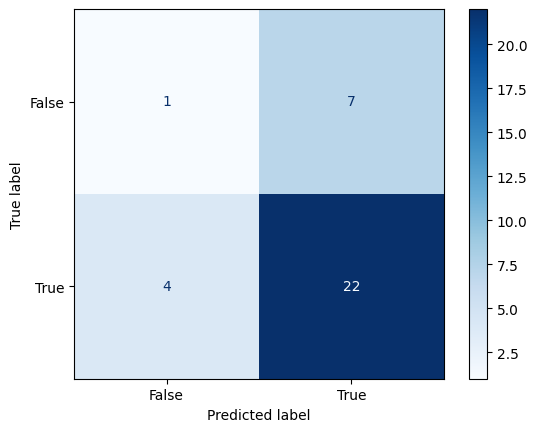

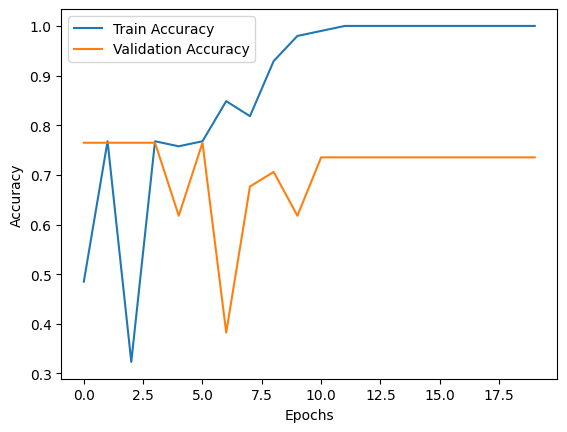

In [11]:
import numpy as np
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define constants
AUDIO_LENGTH = 30  # in seconds
SAMPLE_RATE = 16000  # in Hz

# Function to convert audio to spectrogram
def audio_to_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=AUDIO_LENGTH)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect_db = librosa.power_to_db(spect, ref=np.max)
    return spect_db

# Function to pad or truncate spectrogram to a fixed size
def pad_or_truncate_spectrogram(spectrogram, fixed_shape):
    if spectrogram.shape[1] > fixed_shape[1]:
        spectrogram = spectrogram[:, :fixed_shape[1]]
    else:
        pad_width = fixed_shape[1] - spectrogram.shape[1]
        spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    return spectrogram

# Process dataset
def process_dataset(df, fixed_shape=None, base_dir='C:/Users/shrra/Downloads/Bridge2AI/bridge2ai-voice-corpus-2-including-sensitive-recordings1/bids_with_sensitive_recordings/'):
    X = []
    y = []
    max_shape = (0, 0)
    
    # First pass to determine the maximum shape if fixed_shape is not provided
    if fixed_shape is None:
        for idx, row in df.iterrows():
            subject_id = row['subject_id']
            session_dir = os.path.join(base_dir, subject_id, 'audio')
            for file_name in os.listdir(session_dir):
                if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):
                    file_path = os.path.join(session_dir, file_name)
                    spectrogram = audio_to_spectrogram(file_path)
                    max_shape = (max(max_shape[0], spectrogram.shape[0]), max(max_shape[1], spectrogram.shape[1]))
                    break
        fixed_shape = max_shape

    # Second pass to process the data
    for idx, row in df.iterrows():
        subject_id = row['subject_id']
        session_dir = os.path.join(base_dir, subject_id, 'audio')
        for file_name in os.listdir(session_dir):
            if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):
                file_path = os.path.join(session_dir, file_name)
                spectrogram = audio_to_spectrogram(file_path)
                spectrogram = pad_or_truncate_spectrogram(spectrogram, fixed_shape)
                X.append(spectrogram)
                y.append(row['new_race___5'])
                break
    return np.array(X), np.array(y), fixed_shape

# Prepare data
X_train, y_train, fixed_shape = process_dataset(train_df)
X_val, y_val, _ = process_dataset(val_df, fixed_shape=fixed_shape)
X_test, y_test, _ = process_dataset(test_df, fixed_shape=fixed_shape)

# Encode labels
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_val = to_categorical(label_encoder.transform(y_val))
y_test = to_categorical(label_encoder.transform(y_test))

# Ensure inputs have the right shape
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(fixed_shape[0], fixed_shape[1], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Display confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Display training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])